# Convolutional Neural Networks

**Outline**

* [Introduction](#intro)
* [How do we detect edges in the image](#idea)
* Technique when applying filter
    * [Padding](#padding)
    * [Strided Convolution](#stride)
* [Convolution Layer: Convolution over Volumn](#volumn)
* [Layer of Convolutional Neural Network](#layer)
* [Pooling Layer](#pooling)
* [Take Away](#takeaway)
* [Example - Cifer10](#cifer)
* [VGG16](#VGG16)
    * [Create VGG16 from Scratch](#vgg_scratch)

---

## <a id='intro'>Introduction</a>

Suppose we have an image with 1000 x 1000 x 3 dimension. We have 3 in the last dimension since it indicate the three layer of colors. To build a model directly using all the values in the pixel we would need 3 million nodes in the input layer of the neural network model. In other words, this matrix will be a 1000 by 3 million dimensional matrix, 
if we have 1000 nodes in the hidden layer. This means that this matrix here will have three billion parameters which is just very, very large. With that many parameters, it's difficult to get enough data to prevent a neural network from overfitting. And also, the computational requirements and the memory requirements to train a neural network with three billion parameters is just a bit infeasible.

In order to build models using image as input, we need to better implement the convolution operation, which is one of the fundamental building blocks of convolutional neural networks.

In [1]:
import numpy as np
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image, display

image_size = 1000

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    # load and combine all the image path to a single list
    imgs = [load_img(img_path) for img_path in img_paths] #, target_size=(img_height, img_width)
    
    # convert each image to array using list comprehension. This will end up in a stack of 3D tensor/array.
    img_array = np.array([img_to_array(img) for img in imgs]) 
    
    # convert the value of each pixel into -1 and 1. 
    # This was done when the model was first built, so we have to do it here to be consistent
    output = preprocess_input(img_array)
    
    return(output)

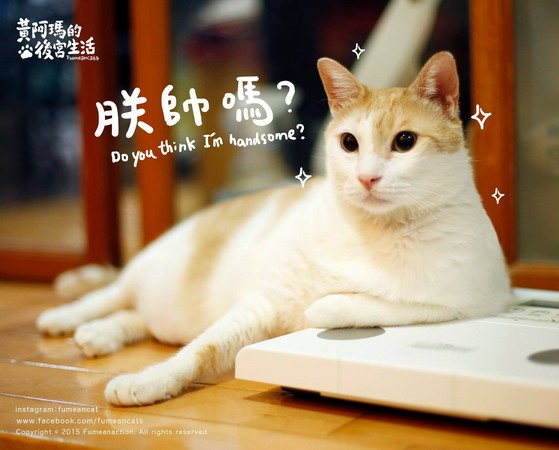

In [2]:
img_path = ['pic/cat.jpg']
display(Image(img_path[0]))

In [3]:
test_data = read_and_prep_images(img_path)

In [4]:
test_data.shape

(1, 450, 559, 3)

I attach a picture of a famous cat from Taiwan above just to show the dimension of the picture that we see usually. As we can see, the dimension in the above picture is (450 x 559 x 3).

## <a id='idea'>How do we detect edges in the image</a>

<img src="pic/edge_1.png" style="width: 500px;height: 300px;"/>

<img src="pic/Convolution_schematic.gif" style="width: 500px;height: 300px;"/>

Let's firstly ocnsider a simple example: how do we detect vertical lines in a image. 
On the left hand side we can see a pixel matrix. It turns out that we can detect the region of the vertical line by applying the so-called *filter* to each of the region of the original pixel matrix. 

In this example, this bright region in the middle is just the output images way of saying that it looks like there is a strong vertical edge right down the middle of the image. Maybe one intuition to take away from vertical edge detection is that a vertical edge is a three by three region since we are using a 3 by 3 filter where there are bright pixels on the left, you do not care that much about what is in the middle and dark pixels on the right.

The middle in this 6 by 6 image is really where there could be bright pixels on the left and darker pixels on the right and that is why it thinks its a vertical edge over there. The convolution operation gives you a convenient way to specify how to find these vertical edges in an image.

More generally, different filters allow us to find vertical and horizontal edges.

Instead of hand coding the values in a filter, one of the things we learned is that when you really want to detect edges in some complicated image, maybe you don't need to have computer vision researchers handpick these nine numbers. Maybe you can just learn them and treat the nine numbers of this matrix as parameters, which you can then learn using back propagation. And the goal is to learn nine parameters so that when you take the image, the six by six image, and convolve it with your three by three filter, that this gives you a good edge detector.

And what we'll see in later videos is that by just treating these nine numbers as parameters, the backprop can choose to learn different kinds of filters from the image that capture the characteristics of your data than any of these hand coded filters.

### <a id='padding'>Padding</a>

> **Why do we need padding?**

Notice that from the simple example above, the output after we convolve the original image using the filter went from 6 by 6 pixels to 4 by 4 pixel. There are two downside of it

1. **Shrinking Output**: You can only do this a few times before your image starts getting really small, maybe it shrinks down to one by one or something, so maybe, you don't want your image to shrink every time you detect edges or to set other features on it.
2. **Throwing away info from edge**: If you look the pixel at the corner or the edge, this little pixel is touched as used only in one of the outputs, because this touches that three by three region. Whereas, if you take a pixel in the middle, say this pixel, then there are a lot of three by three regions that overlap that pixel and so, is as if pixels on the corners or on the edges are use much less in the output. So you're throwing away a lot of the information near the edge of the image

In order to fix both of these problems, what you can do is the full apply of convolutional operation. You can pad the image. So in this case, let's say you pad the image with an additional one border, with the additional border of one pixel all around the edges. So, if you do that, then instead of a six by six image, you've now padded this to eight by eight image and if you convolve an eight by eight image with a three by three image you now get that out. Now, the four by four by the six by six image, so you managed to preserve the original input size of six by six.

> **How much should we pad to the original image to address the problems described above?**

It turns out there two common choices that are called, Valid convolutions and Same convolutions.

* **Valid Convolution**: this basically means no padding
* **Same Convolution**: the output size is the same as the input size.
    * Assume the original image is n by n, our filter is f by f. The output of it will be n-f+1
    * If we add padding, the dimension of the image will become n+2p, and the outout will become n+2p-f+1
    * If we want the dimension of the output to be the same as the input, we want n+2p-f+1 = n. Therefore, p=$\frac{f-1}{2}$
    * So when f is odd, by choosing the padding size to be as follows, you can make sure that the output size is same as the input size

By convention, f is usually an odd number, and there are probably two reasons for that

1. if f was even, then you need some asymmetric padding. So only if f is odd that this type of same convolution gives a natural padding region, had the same dimension all around rather than pad more on the left and pad less on the right, or something that asymmetric. 
2. when you have an odd dimension filter, such as three by three or five by five, then it has a central position and sometimes in computer vision its nice to have a distinguisher, it's nice to have a pixel, you can call the central pixel so you can talk about the position of the filter.

### <a id='stride'>Strided Convolution</a>

(To reduce the model training time, we can use a technique called striede)

Instead of moving 1 pixel at a time, we can move 2 pixels at a time when applying the filter to the image (convoling the image using the filter).

## <a id='volumn'>Convolution Layer: Convolution over Volumn</a>

For a RGB image, it have three dimensions. Let's call the dimension height, width and channels. Channels indicate the three layer of colors. To apply filter to a RGB image, we need three channels for the filter as well.

An image with 6 x 6 x 3, convolving with 3 x 3 x 3 filter, the output will be a 4 x 4 matrix.
If you want to detect edges in the red channel of the image, then you could have the first filter, with the filter that detecting vertical line, have the green channel be all zeros, and have the blue filter be all zeros. And if you have these three stock together to form your three by three by three filter, then this would be a filter that detect edges, vertical edges but only in the red channel.

Alternatively, if you don't care what color the vertical edge is in, then you might have three filter to be the same using the vertical line edge detecting filter.

Remind that the number of channels in the image and the filter should always be the same in order for the filter to apply to the image.


The idea of convolution on volumes, turns out to be really powerful. Only a small part of it is that you can now operate directly on RGB images with three channels. But even more important is that you can now detect two features, like vertical, horizontal edges, or 10, or maybe a 128, or maybe several hundreds of different features. And the output will then have a number of channels equal to the number of features you are detecting.

To better understand how the output of the convolutional layers after applying filters (or kernels) is, we can see the  following image copied from [Stanford's cs231 github io](http://cs231n.github.io/convolutional-networks/). As we can see below, the original input volumn is (5 x 5 x 3), after adding padding equals to 1, the volumns becomes (7 x 7 x 3). We also use stride equals to 2. Also, since the number of channels in a filter should be the same as the number of channel in input, in our filter we have the size (3 x 3 x 3). What we then want to calculate is to apply the each channel in the filter to the corresponding channel in the input volumn, and then sum up the value across all the channels, i.e., the output after applying a filter in one volumn is a single value. In this example, we actually have two filters, therefore, the output of applying two filters to the input volumn is then (3 x 3 x 2).

<img src="pic/cnn_volumn.png" style="width: 500px;height: 400px;"/>

> **Share weight vs Non-sharing weight**

In the above example, let's assume we have only 1 color, i.e, 1 layer. If we think about the input as a (5 x 5)= 25 vector, the input layer we have 25 values. With the same condition, the output of the convolution is with 9 neurons. Each input is connected with the neuron in the first hidden layer, therefore, we will have (25 x 9) weights if we don't share the weights in the filter. 

If we share the weight, the number of weight is 9. The picture below shows how CNN can be represent as a original neural network format.

<img src="pic/fCNN.png" style="width: 400px;height: 450px;"/>

## <a id='layer_cnn'>Layer of Convolutional Neural Network</a>

From the previous discussion, we know that changing the weight in a filter can help us detecting some certain features. We can apply multiple filters to the input in each layer to detect more features. 

How will the network do when we go deeper to the network? The following paragraph quoted from the [blog post: A Beginner's Guide To Understanding Convolutional Neural Networks] described it clearly:

```
When we go through another conv layer, the output of the first conv layer becomes the input of the 2nd conv layer.  Now, this is a little bit harder to visualize. When we were talking about the first layer, the input was just the original image. However, when we’re talking about the 2nd conv layer, the input is the activation map(s) that result from the first layer. So each layer of the input is basically describing the locations in the original image for where certain low level features appear. Now when you apply a set of filters on top of that (pass it through the 2nd conv layer), the output will be activations that represent higher level features. Types of these features could be semicircles (combination of a curve and straight edge) or squares (combination of several straight edges). As you go through the network and go through more conv layers, you get activation maps that represent more and more complex features. By the end of the network, you may have some filters that activate when there is handwriting in the image, filters that activate when they see pink objects, etc.
```
> **How many parameters do a certain layer have?**

let's go through an exercise. Let's suppose you have 10 filters, not just two filters, that are 3 by 3 by 3 and 1 layer of a neural network, how many parameters does this layer have? 

Each filter, is a 3 x 3 x 3 volume, so 3 x 3 x 3, so each fill has 27 parameters. There's 27 numbers to be run, and plus the bias. so this gives you 28 parameters. 

Now if you imagine that you actually have ten of these, then all together you'll have 28 times 10, so that will be 280 parameters. Notice one nice thing about this is that no matter how big the input image is, the input image could be 1,000 by 1,000 or 5,000 by 5,000, but the number of parameters you have still remains fixed as 280. And you can use these ten filters to detect features, vertical edges, horizontal edges maybe other features anywhere even in a very, very large image is just a very small number of parameters.


> **Another questions is that if filters along can help us detect features in a image, how do the activation function come into play?**

For the original neural network, we use sigmoid function as the activation function because we want to add non-linearity to the network. Otherwise, the network would only ever be able to compute a linear function. Is it the same reason for using activation function in CNN?

The following link may help

* [Quora: what is activation in CNN](https://www.quora.com/What-is-activation-in-convolutional-neural-networks)
* [A Beginner's Guide To Understanding Convolutional Neural Networks Part 2](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)
    * The purpose of this layer is to introduce nonlinearity to a system that basically has just been computing linear operations during the conv layers
* [ReLu and Dropout in CNN](https://stackoverflow.com/questions/27319931/relu-and-dropout-in-cnn)    
    * The rectifier activation function is used instead of a linear activation function to add non linearity to the network, otherwise the network would only ever be able to compute a linear function.
* [Layers of a Convolutional Neural Network](https://wiki.tum.de/display/lfdv/Layers+of+a+Convolutional+Neural+Network#LayersofaConvolutionalNeuralNetwork-ConvolutionalLayer)    
    * A non-linearity layer in a convolutional neural network consists of an activation function that takes the feature map generated by the convolutional layer and creates the activation map as its output
    * It is noteworthy that, although this wiki seperates the non-linearity layer from convolutional layer, it is not uncommon to see a combination of the non-linearity layer with the convolutional layer in the literature.
* [Deeplearning.ai: Why do you need non-linear activation functions?](https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions)    
    * because on the composition of two linear functions is itself a linear function so unless you throw a non-linearity in there then you're not computing more interesting functions even as you go deeper in the network
    
> **Assuming that we accept that by adding non-linearity layer to CNN, how do adding non-linearity to the model help us detect more interesting feature of the image?**



## <a id='pooling'>Pooling Layers</a>

Other than convolutional layers, ConvNets often also use pooling layers to reduce the size of the representation, to speed the computation, as well as make some of the features that detects a bit more robust.

<img src="pic/maxpool.png" style="width: 500px;height: 300px;"/>

The following paragraph are quoted from [A Beginner's Guide To Understanding Convolutional Neural Networks Part 2](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)

```
The intuitive reasoning behind this layer is that once we know that a specific feature is in the original input volume (there will be a high activation value), its exact location is not as important as its relative location to the other features. As you can imagine, this layer drastically reduces the spatial dimension (the length and the width change but not the depth) of the input volume. This serves two main purposes. 

* The first is that the amount of parameters or weights is reduced by 75%, thus lessening the computation cost. 
* The second is that it will control overfitting. This term refers to when a model is so tuned to the training examples that it is not able to generalize well for the validation and test sets. A symptom of overfitting is having a model that gets 100% or 99% on the training set, but only 50% on the test data.
```



## <a id='takeaway'>Take Away</a>

To build up a CNN, we need to define filter size, and the size of the filter is the number of parameters we want to train from the model.

We add several convolutional layers. Notice that after applying filter to the input, we get the feature map, instead of just use that as the input of the next layer, we need to apply activation function to it so that we have a non-linear model. 

Then, depending on how many layer we want to add, the model will have different kinds of structure. Some of the layer we can add are
* **Pooling Layer**: prevent overfitting as well as make training faster

Some technique we can use when applying filter to the input volumn includes
* **Padding**: to prevent input from shrinking 
* **Stride**: to make training faster

In order to map the layer to the actual category we want to predict, in the last layer we usually fully connected layer with softmax function to estimate the final probabilty. To see an example of CNN, lenet-5, check this [video](https://www.coursera.org/learn/convolutional-neural-networks/lecture/uRYL1/cnn-example)

## <a id='cifer'>Example - Cifer 10</a>

In [5]:
%matplotlib inline

import keras
from keras.datasets import cifar10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


To show an example of how to build a CNN model to classify images, I choose a 'hello world' dataset called [Cifer 10](http://www.cs.toronto.edu/~kriz/cifar.html). 

Here is a short description of the dataset:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:
<img src="pic/cifer.png" style="width: 400px;height: 300px;"/>

The following code is used in the **MSiA 432 Deep Learning Course** provided by **Professor Ellick Chan** and **Jaehoon Koo**.

The code implemented the following features from scratch

* **Number of epoch**: the number of iterations for model training.
* **Early stopping**: if the validation accuracy doesn't change after ***n_stopping***, then the training will stop.
* **Mini Batch**: the number of images to update each epoch
* **Save Model**: save the trained model to the specified directory
* **Manually separate data into training and validation**


In [6]:
# the current directory. change this to your directory
directory = '/Users/johnnychiu/Desktop/MyFiles/learning/Machine-Learning/DeepLearning/cnn/model/'

In [7]:
import keras
from keras.datasets import cifar10
from keras.models import Model,Sequential,load_model
from keras.layers import Input,Dense,Dropout,Flatten,Conv2D,MaxPooling2D,LeakyReLU
from keras.regularizers import l1_l2
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn import metrics
import numpy as np
import time,glob
#from imblearn.over_sampling import SMOTE as smote
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt

In [8]:
def build_model_cnn_1(shape,n_cls): 
    """
    build model using keras functional API
    """
    # Specify the input_shape for the first Conv2D layer.
    inputs = Input(shape=shape)
    
    # Add Conv2D layers with 128 filters, a kernel_size of 3 * 3, a relu activation, and use same padding with stride equals to 2.
    c1 = Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same', strides=2)(inputs)

    # Add max pooling with 3 * 3 region, also use same padding to make the output to have the same dimension
    m1 = MaxPooling2D(pool_size=(3,3),padding='same')(c1)
    
    # Add Conv2D layers with 64 filters, a kernel_size of 3 * 3, a relu activation, and use same padding with stride equals to 2.
    c2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same', strides=2)(m1)
    
    # Add max pooling with 3 * 3 region
    m2 = MaxPooling2D(pool_size=(3,3))(c2)
    
    # Flatten the convolutional layer for fully connected layer
    f1 = Flatten()(m2)
    
    # Add a Dense layer with specified number of class after the Flatten layer.
    out = Dense(n_cls,activation='softmax')(f1)
    
    # combine the in and out as our final model
    model = Model(inputs=inputs,outputs=out)
    return model

In [9]:
def build_model_cnn_2(shape,n_cls):
    """
    build model using keras sequential API
    One CNN layer 
    """    
    # Create a Sequential model
    model = Sequential()
    
    # Add a Conv2D layer with 12 filters, a kernel_size of (3 x 3), a relu activation. 
    # You will need to specify the input_shape for the first Conv2D layer. 
    # The input shape in this case is (img_rows, img_cols, 3).
    model.add(Conv2D(64, (3, 3), padding='same',input_shape=shape,activation='relu'))
    
    # Add max pooling with 3 * 3 region
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    
    # Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    model.add(BatchNormalization())
    
    # Flatten the convolutional layer for fully connected layer
    model.add(Flatten())
    
    # Add a Dense layer with 256 nodes
    model.add(Dense(256,activation='relu'))
    
    # Normalize the activations of the previous layer at each batch
    model.add(BatchNormalization())
    
    # Add a Dense layer with number of class and using softmax as activation function
    model.add(Dense(n_cls,activation='softmax'))
    return model  

In [14]:
def load_data():
    # The data, shuffled and split between train and test sets:
    (trainx, trainy), (testx, testy) = cifar10.load_data()

    trainx = trainx.astype('float32')/255.
    testx = testx.astype('float32')/255.

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    return trainx,trainy,testx,testy


def main():
    
    # input shape and number of classes
    input_shape = (32,32,3) # this should be same as trainx.shape[1:])
    n_cls = 10

    # The data, shuffled and split between train and test sets:
    trainx,trainy,testx,testy = load_data()

    # build model 
    model = build_model_cnn_1(input_shape,n_cls) # change your model
    
    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop()

    # Let's train the model 
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    # split train into train and validation
    vallen = int(0.2*len(trainx)) 
    rng = np.random.randint(0,len(trainx),vallen)
    # create validation set
    valx = trainx[rng]
    valy = trainy[rng]
    # create train set for learning
    trainx = np.delete(trainx,rng,axis=0)
    trainy = np.delete(trainy,rng,axis=0)

    # Initialization 
    n_epoch = 10
    n_stopping = 5
    best_val = 1000
    patience = 0
    mini_batch_size = 128
    epoch = 0
    saved = False
    # address to save model, change this to your directory
    address = directory+'cifarconv.h5' 
    
    # model training
    while (patience<n_stopping) and (epoch<n_epoch): # stop if patience >= 5 or epoch >= n_epoch
        first = time.time()
        
        # fit model
        hist = model.fit(trainx, trainy,batch_size=mini_batch_size,epochs=1,validation_data=(valx,valy),shuffle=True,verbose=0)

        # make prediction
        predictions = model.predict(valx,verbose=0)
        f1tempscore = metrics.f1_score(y_true=np.argmax(valy, axis=1),y_pred=np.argmax(predictions, axis=1), average=None)
        epoch+=1
        f1avgscore = np.mean(f1tempscore)
        end = time.time()
        # printing current results
        print('--------------------------------------------------------')
        print('Epoch' + str(epoch) + ' took %.4f Seconds' %(end-first) )
        print('Training Loss is %.4f' %hist.history['loss'][0])
        print('Validation Loss is %.4f' %hist.history['val_loss'][0])
        print('Validation Accuracy is %.4f' %hist.history['val_acc'][0])
        print('F1 Score is %.4f' %f1avgscore)
        # checking finish training
        current_val = hist.history['val_loss'][0]
        # current training is better than before
        if current_val<best_val:
            best_val = current_val
            patience = 0
            print('New Model Saved at epoch' + str(epoch) + ' at' + address)
            model.save(address)
            saved = True
        # No improvement
        else: 
            patience+=1
            print ('Current patience is ' + str(patience))
    
    # if best model is not found during n_epoch
    if not saved:
        print('No best model is saved until epoch'+ str(epoch))
        print('Considier training more')
        print('New Model Saved at epoch' + str(epoch) + ' at' + address)
        model.save(address)        
    # delete current model
    del model
    
    # load saved best model
    model = load_model(address)

    # Now we try against the test set using evaluate method from model class api
    print ('Inference on test set')
    eval_ = model.evaluate(testx,testy,verbose=1)
    print('Test loss: %.4f ...Test accuracy: %.4f' %(eval_[0],eval_[1]))
    predictions = model.predict(testx)

    
    ##### Using heatmap to plot out the confusion matrix
    # Use predictions to make some descent histograms...
    testreal = np.argmax(testy,axis=1)
    testpred = np.argmax(predictions,axis=1)
    
    figsave = directory+'Heatmap_cifar.png'
    mat = np.zeros((n_cls,n_cls),dtype=np.int) # x: real y: pred
    for i in range(len(testreal)):
        prd_temp = testpred[i]
        acc_temp = testreal[i]
        mat[acc_temp, prd_temp] += 1       
    
    pct = mat/mat.sum(axis=1)[:,None]
    x = range(n_cls+1)
    y = range(n_cls+1)
    x, y = np.meshgrid(x, y)
    x_ticks_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] #np.unique(testreal)
    fig, ax = plt.subplots()
    plt.pcolormesh(x, y, pct)  #### color    
    plt.colorbar()
    ax.set_yticks(np.arange(pct.shape[0])+0.5, minor=False)
    ax.set_yticklabels(x_ticks_labels, minor=False)
    ax.set_xticks(np.arange(pct.shape[0])+0.5, minor=False)
    ax.set_xticklabels(x_ticks_labels, rotation=45, minor=False)
    plt.xlabel('Pred')
    plt.ylabel('Real')
    plt.title('Heatmap')
    plt.savefig(figsave)
    return trainx,trainy,testx,testy,model

--------------------------------------------------------
Epoch1 took 17.2976 Seconds
Training Loss is 1.9142
Validation Loss is 1.7112
Validation Accuracy is 0.3977
F1 Score is 0.3890
New Model Saved at epoch1 at/Users/johnnychiu/Desktop/MyFiles/learning/Machine-Learning/DeepLearning/cnn/model/cifarconv.h5
--------------------------------------------------------
Epoch2 took 15.6457 Seconds
Training Loss is 1.6195
Validation Loss is 1.5379
Validation Accuracy is 0.4537
F1 Score is 0.4380
New Model Saved at epoch2 at/Users/johnnychiu/Desktop/MyFiles/learning/Machine-Learning/DeepLearning/cnn/model/cifarconv.h5
--------------------------------------------------------
Epoch3 took 15.9692 Seconds
Training Loss is 1.4954
Validation Loss is 1.4598
Validation Accuracy is 0.4740
F1 Score is 0.4615
New Model Saved at epoch3 at/Users/johnnychiu/Desktop/MyFiles/learning/Machine-Learning/DeepLearning/cnn/model/cifarconv.h5
--------------------------------------------------------
Epoch4 took 14.8138

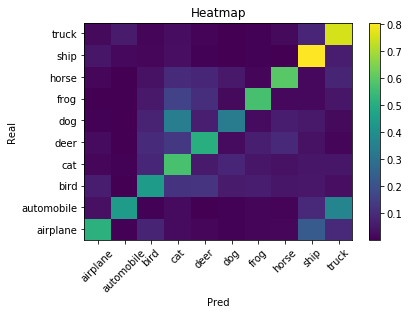

In [15]:
trainx,trainy,testx,testy,model = main()

### Let's also plot out the image and the result to get a better sense of it

In [16]:
model = load_model(directory+'cifarconv.h5')

In [17]:
predictions = model.predict(testx) 

Prediction: cat
Probability: 0.53886


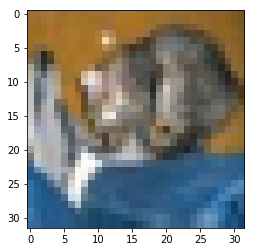

--------------------------------------
Prediction: ship
Probability: 0.649164


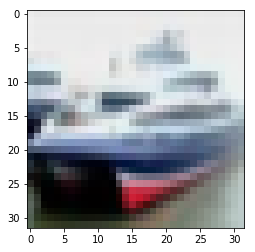

--------------------------------------
Prediction: ship
Probability: 0.821561


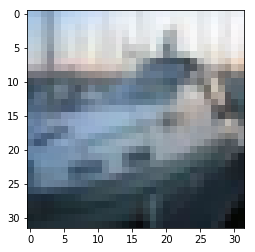

--------------------------------------
Prediction: ship
Probability: 0.856734


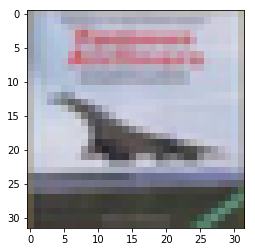

--------------------------------------
Prediction: frog
Probability: 0.544456


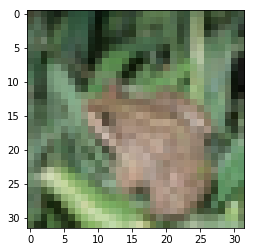

--------------------------------------
Prediction: frog
Probability: 0.516454


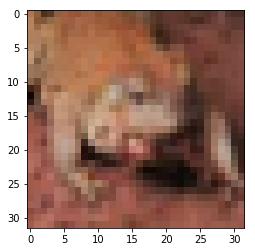

--------------------------------------
Prediction: truck
Probability: 0.752487


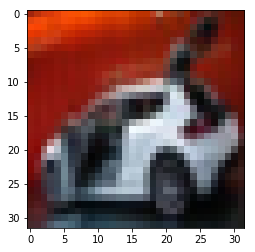

--------------------------------------
Prediction: frog
Probability: 0.438443


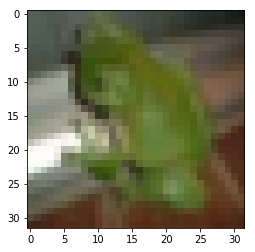

--------------------------------------
Prediction: cat
Probability: 0.388575


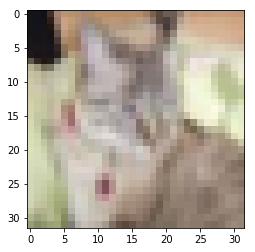

--------------------------------------
Prediction: automobile
Probability: 0.672431


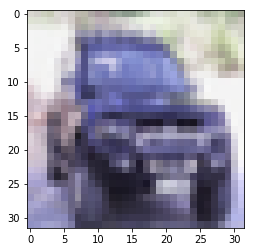

--------------------------------------


In [18]:
x_ticks_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] #np.unique(testreal)
for i in range(10):
    plt.imshow(testx[i]) #, cmap='gray'
    print("Prediction:", x_ticks_labels[np.argmax(predictions[i])]) 
    print("Probability:", predictions[i][np.argmax(predictions[i])])     
    plt.show()
    print("--------------------------------------")

Since we only train 10 epochs, the overall accuracy is actually not high. That'w why we can find in the output that many of the images are misclassified.

## <a id='vgg16'>VGG16</a>

As described in this [Keras blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html), VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) from Oxford, who developed it. It was used to win the [ILSVR (ImageNet) competition in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/). To this day is it still considered to be an excellent vision model, although it has been somewhat outperformed by more revent advances such as Inception and ResNet.

> **Description of layers**

<img src="pic/vgg_layers.png" style="width: 600px;height: 200px;"/>

> **Full View at image level**

<img src="pic/vgg_imageview.png" style="width: 600px;height: 300px;"/>

Since VGG16 is widely used, we can directly import the pre-trained model from keras to do [transfer learning](http://nbviewer.jupyter.org/github/johnnychiuchiu/Machine-Learning/blob/master/DeepLearning/transferLearning.ipynb) by excluding the fully connected layer. The reason is that adding the fully connected layers forces you to use a fixed input size for the model (224x224, the original ImageNet format). By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes.

In [19]:
from keras import applications

# build the VGG16 network
model_vgg = applications.VGG16(include_top=False,
                           weights='imagenet')

### <a id='vgg_scratch'>Create VGG16 from scratch</a>

For learning purpose, we can actually create a VGG16 model from scratch using both functional and sequantial API from Keras.

In [20]:
def build_model_vgg16_1(shape,n_cls): # functional model
    img_input = Input(shape=shape)
    # Block 1
    x = LeakyReLU(0.2)(Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input))
    x = LeakyReLU(0.2)(Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x))
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = BatchNormalization()(x)
    # Block 2
    x = LeakyReLU(0.2)(Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x))
    x = LeakyReLU(0.2)(Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x))
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = BatchNormalization()(x)
    # Block 3
    x = LeakyReLU(0.2)(Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x))
    x = LeakyReLU(0.2)(Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x))
    x = LeakyReLU(0.2)(Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x))
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = BatchNormalization()(x)
    # Block 4
    x = LeakyReLU(0.2)(Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x))
    x = LeakyReLU(0.2)(Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x))
    x = LeakyReLU(0.2)(Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x))
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    x = BatchNormalization()(x)
    # Block 5
    x = LeakyReLU(0.2)(Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x))
    x = LeakyReLU(0.2)(Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x))
    x = LeakyReLU(0.2)(Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x))
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = BatchNormalization()(x)
    # output layer
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(0.01,0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(n_cls, activation='softmax', name='predictions')(x)

    inputs = img_input
    model = Model(inputs, x, name='vgg16') 
    return model

In [21]:
def build_model_vgg16_2(shape,n_cls): # sequential model
    # build model 
    model = Sequential()
    # block 1 
    model.add(Conv2D(64, (3, 3), padding='same',input_shape=shape,activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    # block 2
    model.add(Conv2D(128, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    # block 3
    model.add(Conv2D(256, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # block 4
    model.add(Conv2D(512, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # fc layer
    model.add(Flatten())
    model.add(Dense(512,activation='relu',kernel_regularizer=regularizers.l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    # output layer
    model.add(Dense(n_cls,activation='softmax'))
    return model    

## Reference


* [Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)
* [Keras Blog: How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [Deeplearning.ai: Convolitional Neural Networks course](https://www.coursera.org/learn/convolutional-neural-networks)
* [Quora: what is VGG neural network](https://www.quora.com/What-is-the-VGG-neural-network)
* [Keras: Model class API](https://keras.io/models/model/)
* [CS231n: Convolutional Neural Networks for visual recongition](http://cs231n.github.io/convolutional-networks/)
* [A Beginner's Guide To Understanding Convolutional Neural Networks Part 2](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)
* [Backpropagation In Convolutional Neural Networks](http://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)